# Tutorial 3: Representation Learning with Manifold Capacity

In our last tutorial, we'll explore how ideas from manifold capacity theory can be adapted for self-supervised representation learning. This tutorial is based on the paper **[Learning Efficient Coding of Natural Images with Maximum Manifold Capacity Representations](https://arxiv.org/abs/2303.03307)** and the accompanying [GitHub codebase](https://github.com/ThomasYerxa/mmcr) from lead author Thomas Yerxa.

In [ ]:
### GOOGLE COLAB SETUP -- ONLY RUN IF WORKING IN COLAB ###
from google.colab import drive
drive.mount('/content/drive')
! git clone https://github.com/SamBT/manifold-capacity-tutorial-iaifi25 
%cd /content/manifold-capacity-tutorial-iaifi25/
! pip install -r requirements.txt

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets
import numpy as np
import matplotlib.pyplot as plt
import einops
from tqdm import tqdm
from helpers import manifold_analysis, manifold_analysis_corr, extractor
from helpers.plotting import network_capacity_summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 3.1 - Augmentation-based self-supervised learning

The basic idea behind self-supervised learning (SSL) is to train a neural network $f_\theta: \mathbb{R}^N \to \mathbb{R}^d$ to learn a low-dimensional ($d \ll N$) representation of some dataset $X$ **directly from the data**, i.e. without any supervisory signal coming from class labels. The best-known example of SSL is something you probably use every day, and which is helping me write this tutorial: Large Language Models (LLMs). LLMs are trained on "next token prediction", essentially predicting the next word in a sentence given the ones that came before. Since no labels are involved this is a self-supervised task, and we can easily scale up the training to eat up every word human beings have ever written.

Our setting will be computer vision, where we usually talk about **augmentation-based** SSL and **contrastive learning**. Without going into too much detail, the basic idea is summarized in this image ([source](https://sh-tsang.medium.com/review-simclr-a-simple-framework-for-contrastive-learning-of-visual-representations-5de42ba0bc66)):

<p align='center'>
    <img src='images/simclr.png' />
</p>

We train the encoder $f_\theta$ by sampling a batch of images and creating $k$ augmentations of each one ($k=2$ in the cartoon). The training objective then encourages the network to map augmented views of the same image close to one another in $\mathbb{R}^d$, while pushing them apart from embeddings of the rest of the images in the batch. For computer vision, the augmentations are usually things like:
1. Random crops/rotations/masks
2. Resizing
3. Gaussian blur/noise
4. Color distortion

<!--- One of the best-known variants of augmentation-based SSL is **SimCLR**, which uses cosine similarity to compare representations of images. The SimCLR loss function is:

$$ \mathcal{L}_{\text{SimCLR}}  = -\sum_{i\in \mathcal{B}}\log\frac{\exp(\text{sim}(\mathbf{z}_i,\tilde{\mathbf{z}}_{i})/\tau)}{\sum_{j\neq i}\exp(\text{sim}(\mathbf{z}_i,\mathbf{z}_j)/\tau)} $$

where $(\mathbf{z}_i,\tilde{\mathbf{z}}_i)$ are a positive pair (augmentations of the same image) and the sum in the denominator runs over all other pairs in the batch, excluding only self-similarity. The outer sum runs over a batch of data. --->

**Note**: Standard practice for SSL is to train an **encoder** $f_\theta$ and **projection head** $g_\phi$ simultaneously, where $g:\mathbb{R}^d \to \mathbb{R}^\ell$ with $\ell < d$. The self-supervised loss is evaluated on the *projections* $g(f(\mathbf{x}))$, but the projection head is discarded for downstream tasks. We use this convention throughout this notebook

## 3.2 - Maximum Manifold Capacity Representations

The Maximim Manifold Capacity Representations ([MMCR](https://arxiv.org/abs/2303.03307)) approach uses ideas from manifold capacity theory to construct a new self-supervised training objective. The basic idea is just what it sounds like: learn an embedding $f_\theta$ that maximizes the manifold capacity of the learned representations. As we saw in Tutorials 1 and 2, manifold capacity is a great tool for analyzing *trained* networks, but it is very computationally expensive and thus infeasible for direct use as a loss function.

To make things tractable we rely on a few facts and simplifying assumptions:
1. If the correlation between centroids of a collection of manifolds is low, the capacity can be approximated by $\phi(R_M\sqrt{D_M})$, where $\phi$ is a monotonically decreasing function

2. If manifolds have an **elliptical** shape, the radius and dimension can be approximated by $$R_M \sqrt{\sum_i \lambda_i^2}, \quad D_M = \frac{\left(\sum_i \lambda_i\right)^2}{\sum_i \lambda_i^2}$$ where $\lambda_i$ are the eigenvalues of the ellipsoid's covariance matrix. 

3. Using the above, we can write $$\alpha = \phi(\sum_i \sigma_i)$$ where $\sigma_i$ are the **singular values of a matrix containing points on the manifold**. The sum $\sum_i \sigma_i$ is known as the **nuclear norm** of this data matrix, which we denote by $||\cdot||_\ast$

The nuclear norm *is* something we can compute quickly and use in a training objective, which we turn to next

### 3.2.1 - The MMCR objective
The MMCR objective for augmentation-based SSL is summarized in the figure below

<p align='center'>
    <img src='images/mmcr.png' />
</p>

We sample a set of augmentations from each image, then compute the centroid of those augmentations in the low-dimensional representation from the neural network. The MMCR objective is designed to maximize the extent of this "centroid manifold" by maximizing its nuclear norm. 

The recipe for training is as follows:
1. For a batch of data (i.e. images) $X \in \mathbb{R}^{B\times D}$, sample $k$ augmentations of each image.

2. Feed everything through a neural network $f_\theta$ to acquire a multi-view embedding $Z \in \mathbb{R}^{B \times d \times k}$. Normalize each embedding to lie on the unit sphere $\mathbb{S}^{d-1}$

3. For each element of the batch, find the **centroid** of its $k$ augmented representations and construct the matrix of centroid $C \in \mathbb{R}^{B\times d}$

4. Compute the **MMCR loss**, which seeks to maximize the nuclear norm of this data matrix $$\mathcal{L}_\text{MMCR} = -||C||_\ast$$

#### **FILL IN CODE**
In the cell below, complete the implementation of the MMCR loss for a batch of data. You can use `torch.linalg.svdvals` to get the singular values of a matrix.

In [2]:
class MMCRLoss(nn.Module):
    """
    MMCR Loss function implementation.
    Based on the original implementation in the MMCR codebase.
    """
    def __init__(self, n_views=2):
        super(MMCRLoss, self).__init__()
        self.n_views = n_views # number of augmented views to expect per image
    
    def forward(self, z):
        """
        Args:
            z: Tensor of shape (batch_size * n_views, feature_dim)
               Contains projections for all views of all images
        
        Returns:
            loss: MMCR loss value
        """
        # Normalize representations to unit sphere
        z = F.normalize(z, dim=-1)
        
        # Reshape to (batch_size, feature_dim, n_views)
        z_local = einops.rearrange(z, "(B N) C -> B C N", N=self.n_views)
        
        # Compute centroids: average across views for each image
        centroids = torch.mean(z_local, dim=-1)  # Shape: (batch_size, feature_dim)
        
        # compute the singular values of the centroid matrix
        sigmas = torch.linalg.svdvals(centroids)
        # sum them to get the nuclear norm
        nuc_norm = torch.sum(sigmas)  # Nuclear norm of the centroids
        
        # MMCR loss (careful about the sign!)
        loss = -nuc_norm 
        
        return loss

### 3.3 - Training with MMCR on CIFAR-10

Let's see how this works in practice by training on CIFAR-10. We start by defining the random augmentations we'll apply to images during training. We will use the same sequence of transformations as most other self-supervised models (e.g. SimCLR), which consists of:
1. A random crop
2. Random horizontal flip (50\% probability)
3. Random color jitter (80% probability)
4. Random conversion to grayscale (20% probability)

For convenience we will define a module that outputs `n_views` random augmentations of an image, which will allow us to experiment training with different numbers of augmentations per image.

In [3]:
cifar10_mean = (0.49139968, 0.48215827 ,0.44653124)
cifar10_std = (0.24703233, 0.24348505, 0.26158768)
class MMCRTransform:
    """
    Data augmentation transform that creates multiple views of each image.
    This is based on the CIFAR implementation from the MMCR codebase.
    """
    def __init__(self, n_views=2, train_transform=True):
        self.n_views = n_views
        
        if train_transform:
            # Training augmentations (stronger)
            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply([
                    transforms.ColorJitter(brightness=0.4, contrast=0.4, 
                                         saturation=0.4, hue=0.1)
                ], p=0.8),
                transforms.RandomGrayscale(p=0.2),
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std)
            ])
        else:
            # If not training, just do the standard normalization
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std)
            ])
    
    def __call__(self, x):
        # Create multiple augmented views
        views = []
        for _ in range(self.n_views):
            views.append(self.transform(x))
        return torch.stack(views)


Let's have a look at what some of these augmentations look like on a sample image:

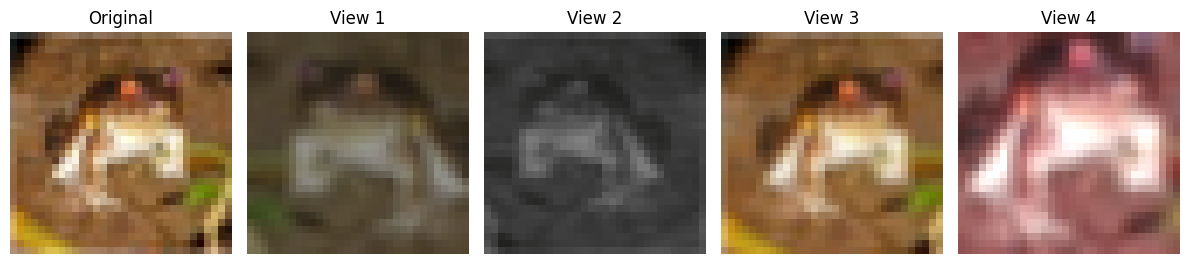

In [4]:
# Load a sample image from CIFAR-10
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                             download=True, transform=None)
sample_image, label = cifar_dataset[0]

transform = MMCRTransform(n_views=4, train_transform=True)
augmented_views = transform(sample_image)

# Visualize the augmented views
def denormalize(tensor):
    mean = torch.tensor(cifar10_mean).view(3, 1, 1)
    std = torch.tensor(cifar10_std).view(3, 1, 1)
    return tensor * std + mean

fig, axes = plt.subplots(1, 5, figsize=(12, 3))

# Show original image
axes[0].imshow(sample_image)
axes[0].set_title('Original')
axes[0].axis('off')

# Show augmented views
for i in range(4):
    img = augmented_views[i] * torch.tensor(cifar10_std).view(3,1,1) + torch.tensor(cifar10_mean).view(3,1,1)
    img = img.permute(1, 2, 0).clamp(0,1)  # Change to HWC format for visualization.
    #img = denormalize(augmented_views[i]).permute(1, 2, 0).clamp(0, 1)
    axes[i+1].imshow(img)
    axes[i+1].set_title(f'View {i+1}')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

Define a convenience function for getting dataloaders with the desired number of views. Note the val/test loaders always just use 1 view with no random augmentation.

In [5]:
def get_loaders(n_views,batch_size,num_workers):
    train_transform = MMCRTransform(n_views=n_views, train_transform=True)
    test_transform = MMCRTransform(n_views=1, train_transform=False)

    # Create datasets with MMCR transforms
    train_dataset = torchvision.datasets.CIFAR10( root='./data', train=True, download=True, transform=train_transform)

    # For validation we'll use the same dataset but no augmentations
    val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=test_transform)

    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=test_transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader

Now let's define a `nn.Module` wrapper for our MMCR embedder. We'll use a `resnet18` backbone for the embedder $f_\theta$ and simple MLP for the projection head $g_\phi$.

#### **FILL IN CODE**

In [6]:
class MMCRModel(nn.Module):
    """
    MMCR Model architecture adapted from the original codebase.
    Consists of a ResNet encoder + projection head.
    """
    def __init__(self, projector_hidden_dims=[512], projector_output_dim=128):
        super(MMCRModel, self).__init__()
        
        # Create ResNet encoder adapted for CIFAR-10
        # We modify the first conv layer for 32x32 images
        resnet = torchvision.models.resnet18(pretrained=False)
        
        # Adapt for CIFAR-10 (32x32 images)
        encoder_layers = []
        for name, module in resnet.named_children():
            if name == "conv1":
                # Use smaller kernel and stride for CIFAR-10
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, 
                                 padding=1, bias=False)
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
                encoder_layers.append(module)
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Projection head
        resnet_output_dim = 512  # Output dimension of resnet18 before the final FC layer
        projector_dims = [resnet_output_dim] + projector_hidden_dims # 512 is the output dimension of the final conv layer of resnet18
        projector_layers = []
        
        for i in range(len(projector_hidden_dims)-1):
            projector_layers.extend([
                nn.Linear(projector_dims[i], projector_dims[i + 1], bias=False),
                nn.BatchNorm1d(projector_dims[i+1]),
                nn.ReLU()
            ])
        
        # Final projection layer (no activation)
        projector_layers.append(
            nn.Linear(projector_hidden_dims[-1], projector_output_dim, bias=False)
        )
        
        self.projector = nn.Sequential(*projector_layers)
    
    def forward(self, x):
        # x shape: (batch_size * n_views, 3, 32, 32)
        batch_size = x.shape[0]
        features = self.encoder(x)
        features = torch.flatten(features, start_dim=1)  # Flatten spatial dimensions
        projections = self.projector(features)
        return features, projections

Now we set up some boilerplate for training

In [7]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch, num_epochs):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    num_batches = 0
    for batch_idx, (images, _) in enumerate(pbar):
        # Reshape images: (batch_size, n_views, 3, 32, 32) -> (batch_size * n_views, 3, 32, 32)
        images = einops.rearrange(images, "B N C H W -> (B N) C H W")
        images = images.to(device, non_blocking=True)
        
        # Forward pass
        optimizer.zero_grad()
        features, projections = model(images)
        loss = loss_fn(projections)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item()
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f"{loss.item():.4f}",
        })
        num_batches += 1
    
    # Return average metrics
    avg_loss = total_loss / num_batches
    return avg_loss

Now train the model! Choose some reasonable value for `n_views`, but note that increases the batch by a factor of `n_views` so if you set too high a number the training will be very slow. You should only need to train for a few epochs to get a useable result.

Epoch 1/5: 100%|██████████| 782/782 [01:14<00:00, 10.54it/s, Loss=-13.7088]


Epoch 1/5: Loss = -46.1642


Epoch 2/5: 100%|██████████| 782/782 [01:15<00:00, 10.32it/s, Loss=-13.5127]


Epoch 2/5: Loss = -50.8078


Epoch 3/5: 100%|██████████| 782/782 [01:17<00:00, 10.14it/s, Loss=-13.5975]


Epoch 3/5: Loss = -52.1195


Epoch 4/5: 100%|██████████| 782/782 [01:09<00:00, 11.22it/s, Loss=-13.9301]


Epoch 4/5: Loss = -52.7958


Epoch 5/5: 100%|██████████| 782/782 [01:14<00:00, 10.45it/s, Loss=-13.7846]


Epoch 5/5: Loss = -53.2273


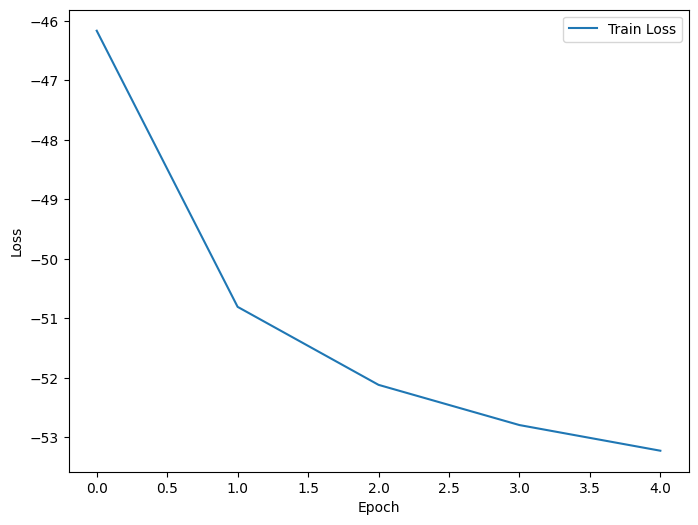

In [9]:
# Initialize model, loss function, and optimizer
n_views = 4
batch_size = 64
num_workers = 2
model = MMCRModel(projector_hidden_dims=[512],projector_output_dim=128).to(device)
loss_fn = MMCRLoss(n_views=n_views)
train_loader, val_loader, test_loader = get_loaders(n_views=n_views, batch_size=batch_size, num_workers=num_workers)

# Training hyperparameters
learning_rate = 1e-3
num_epochs = 5  # Reduced for tutorial (original paper uses 800+ epochs)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training tracking
train_losses = []


for epoch in range(num_epochs):
    # Train for one epoch
    loss = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch, num_epochs)
    
    # Store metrics
    train_losses.append(loss)
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}: Loss = {loss:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
# save the model in case something goes wrong (e.g. kernel crash) - this way you won't need to retrain
torch.save(model, 'mmcr_model.pth')
model = model.eval()

In [ ]:
# uncomment these lines if you need to reload your trained model
#model = torch.load('mmcr_model.pth',weights_only=False)
#model = model.to(device)
#model=model.eval()

### 3.4 - Analyze MMCR Representations

Assuming your model training went well, now you can analyze the learned representations the same way as we did in Tutorial 2. Let's start by looking at **class manifolds** - i.e. constructed from multiple exemplars of the same class. We'll look at augmentation manifolds afterwards (these are what the model is really trained on).

In [21]:
# get some test data
num_test_images = 200 # shoot for 20 per class

num_sampled  = 0
images = []
labels = []
for batch, lab in test_loader:
    images.append(batch.squeeze(1)) # remove the view dimension, which should just be 1 for the test set anyway
    labels.append(lab)
    num_sampled += batch.shape[0]
    if num_sampled >= num_test_images:
        break
images = torch.cat(images, dim=0)[:num_test_images]
labels = torch.cat(labels, dim=0)[:num_test_images]

activations, layer_names = extractor(model, images, labels, layer_types=['Linear','Conv2d'])

Some of the activations will be very high-dimensional since we're using a large backbone. To ease the computational burden a bit we'll project anything with $>5000$ dimensions to 5000 dimensions using a random projection:

In [25]:
for k in tqdm(activations.keys()):
    if k == 'labels':
        continue
    activations[k] = activations[k].reshape(activations[k].shape[0], -1)  # Flatten spatial dimensions
    if activations[k].shape[1] > 5000:
        # If the feature dimension is too large, reduce it with a random projection
        M = np.random.randn(1000,activations[k].shape[1])
        M = M / np.linalg.norm(M, axis=1, keepdims=True)
        activations[k] = np.matmul(activations[k],M.T)

100%|██████████| 23/23 [00:26<00:00,  1.14s/it]


Here we copy our function from Tutorial 2 to run the mean-field manifold capacity computations on the activations

In [22]:
def capacity_analysis(activations, num_per_label=20):
    # Get a sorted list of MNIST labels
    labels = sorted(list(set(activations['labels'])))

    alphas = {l:[] for l in labels}
    radii = {l:[] for l in labels}
    dims = {l:[] for l in labels}
    mean_alphas = []
    mean_radii = []
    mean_dims = []

    # loop through the raw inputs + each layer of the network
    for layer_name in activations.keys():
        if layer_name == 'labels':
            continue
        print(f"Processing activations for layer: {layer_name}")
        # retrieve corresponding activations
        acts = activations[layer_name]

        # construct point clouds for each mnist class
        point_clouds = []
        for l in labels:
            mask = activations['labels'] == l
            point_clouds.append(acts[mask][:num_per_label].T) # limit the number of samples per class to num_per_label
        
        # compute manifold capacity, radius, and dimension 
        alpha, radius, dim = manifold_analysis(point_clouds, kappa=0, n_t=300)

        # fill dictionaries with label-specific results
        for i,l in enumerate(labels):
            alphas[l].append(alpha[i])
            radii[l].append(radius[i])
            dims[l].append(dim[i])

        # compute mean values for alpha, radius, and dimension across the mnist classes
        mean_alpha = 1.0/np.mean(1.0/alpha)
        mean_radius = np.mean(radius)
        mean_dim = np.mean(dim)
        
        mean_alphas.append(mean_alpha)
        mean_radii.append(mean_radius)
        mean_dims.append(mean_dim)
    return alphas, radii, dims, mean_alphas, mean_radii, mean_dims, labels

And run the computations:

In [26]:
alphas, radii, dims, mean_alphas, mean_radii, mean_dims, labels = capacity_analysis(activations)

Processing activations for layer: inputs
Processing activations for layer: layer_1_Conv2d
Processing activations for layer: layer_4_Conv2d
Processing activations for layer: layer_7_Conv2d
Processing activations for layer: layer_9_Conv2d
Processing activations for layer: layer_12_Conv2d
Processing activations for layer: layer_14_Conv2d
Processing activations for layer: layer_17_Conv2d
Processing activations for layer: layer_19_Conv2d
Processing activations for layer: layer_21_Conv2d
Processing activations for layer: layer_24_Conv2d
Processing activations for layer: layer_26_Conv2d
Processing activations for layer: layer_29_Conv2d
Processing activations for layer: layer_31_Conv2d
Processing activations for layer: layer_33_Conv2d
Processing activations for layer: layer_36_Conv2d
Processing activations for layer: layer_38_Conv2d
Processing activations for layer: layer_41_Conv2d
Processing activations for layer: layer_43_Conv2d
Processing activations for layer: layer_45_Conv2d
Processing ac

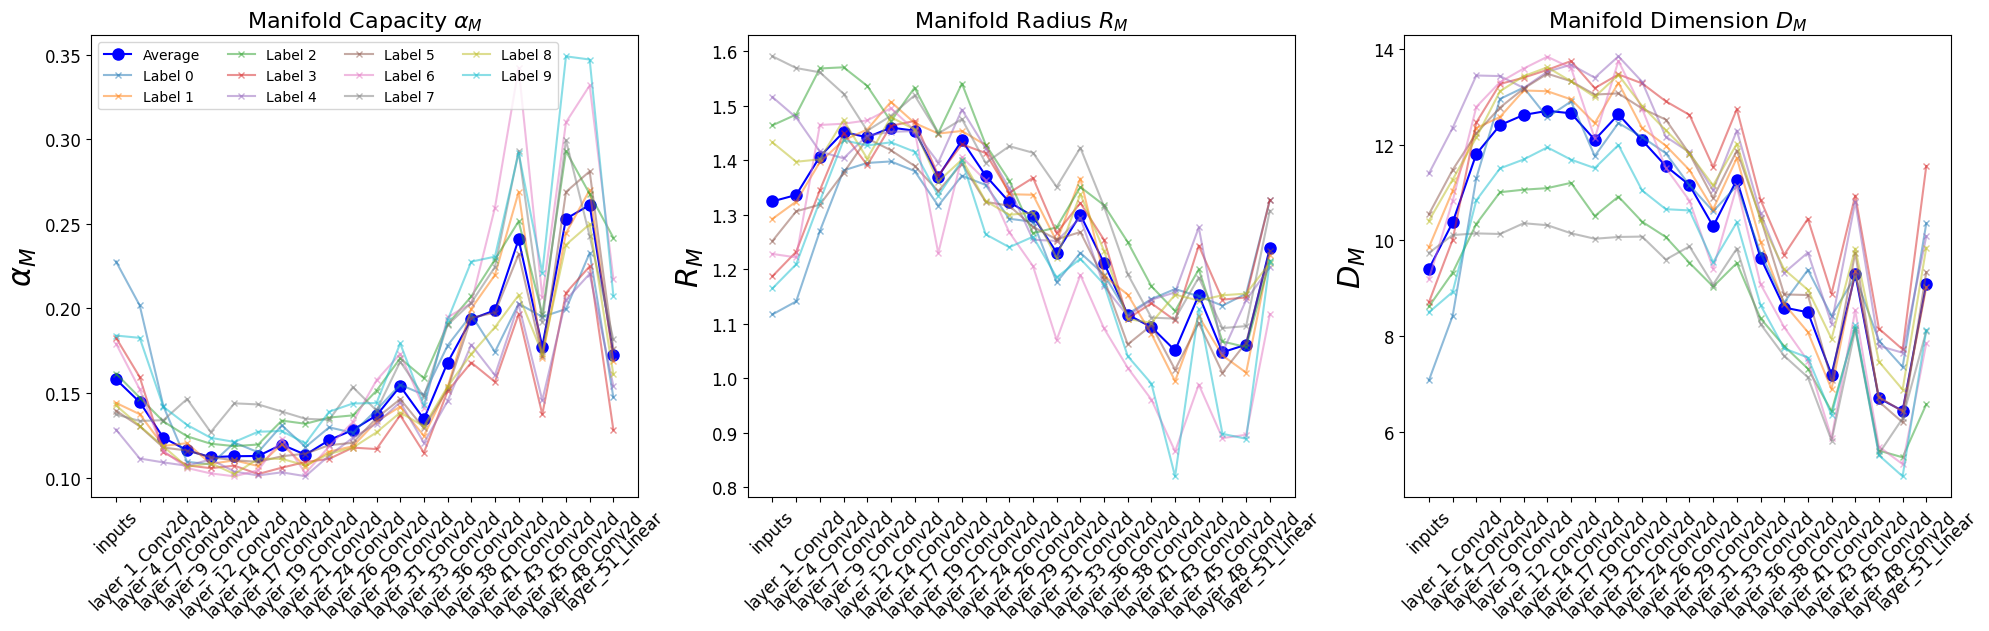

In [27]:
network_capacity_summary(alphas,radii,dims,mean_alphas,mean_radii,mean_dims,layer_names,labels)

**Question**: are these results what you expected? Recall that these are class manifolds, not augmentation manifolds -- the model has been given no class-specific information during training! The results here will depend somewhat on how long you trained your model for and/or how many views you gave it per image.

Let's repeat the same exercise for the **augmentation manifolds**. We'll sample `n_transforms = 20` views of each of the 10 classes (feel free to change this)

In [30]:
n_views = 20
aug_manifold_transform = MMCRTransform(n_views=n_views, train_transform=True)
aug_dset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=aug_manifold_transform)
aug_loader = DataLoader(aug_dset, batch_size=50, shuffle=True)
batch, batch_labels = next(iter(aug_loader))

images = []
labels = []
cifar_labels = np.arange(10)  # CIFAR-10 labels are 0-9
for lab in cifar_labels:
    x = batch[batch_labels == lab][0] # take first exemplar with its n_views views
    images.append(x)
    labels.append(lab*np.ones(n_views, dtype=int))
images = torch.cat(images, dim=0)
labels = torch.tensor(np.concatenate(labels, axis=0))

activations, layer_names = extractor(model, images.to(device), labels, layer_types=['Linear','Conv2d'])

In [31]:
for k in tqdm(activations.keys()):
    if k == 'labels':
        continue
    activations[k] = activations[k].reshape(activations[k].shape[0], -1)  # Flatten spatial dimensions
    if activations[k].shape[1] > 5000:
        # If the feature dimension is too large, reduce it with a random projection
        M = np.random.randn(1000,activations[k].shape[1])
        M = M / np.linalg.norm(M, axis=1, keepdims=True)
        activations[k] = np.matmul(activations[k],M.T)

100%|██████████| 23/23 [00:25<00:00,  1.13s/it]


In [32]:
alphas, radii, dims, mean_alphas, mean_radii, mean_dims, labels = capacity_analysis(activations)

Processing activations for layer: inputs
Processing activations for layer: layer_1_Conv2d
Processing activations for layer: layer_4_Conv2d
Processing activations for layer: layer_7_Conv2d
Processing activations for layer: layer_9_Conv2d
Processing activations for layer: layer_12_Conv2d
Processing activations for layer: layer_14_Conv2d
Processing activations for layer: layer_17_Conv2d
Processing activations for layer: layer_19_Conv2d
Processing activations for layer: layer_21_Conv2d
Processing activations for layer: layer_24_Conv2d
Processing activations for layer: layer_26_Conv2d
Processing activations for layer: layer_29_Conv2d
Processing activations for layer: layer_31_Conv2d
Processing activations for layer: layer_33_Conv2d
Processing activations for layer: layer_36_Conv2d
Processing activations for layer: layer_38_Conv2d
Processing activations for layer: layer_41_Conv2d
Processing activations for layer: layer_43_Conv2d
Processing activations for layer: layer_45_Conv2d
Processing ac

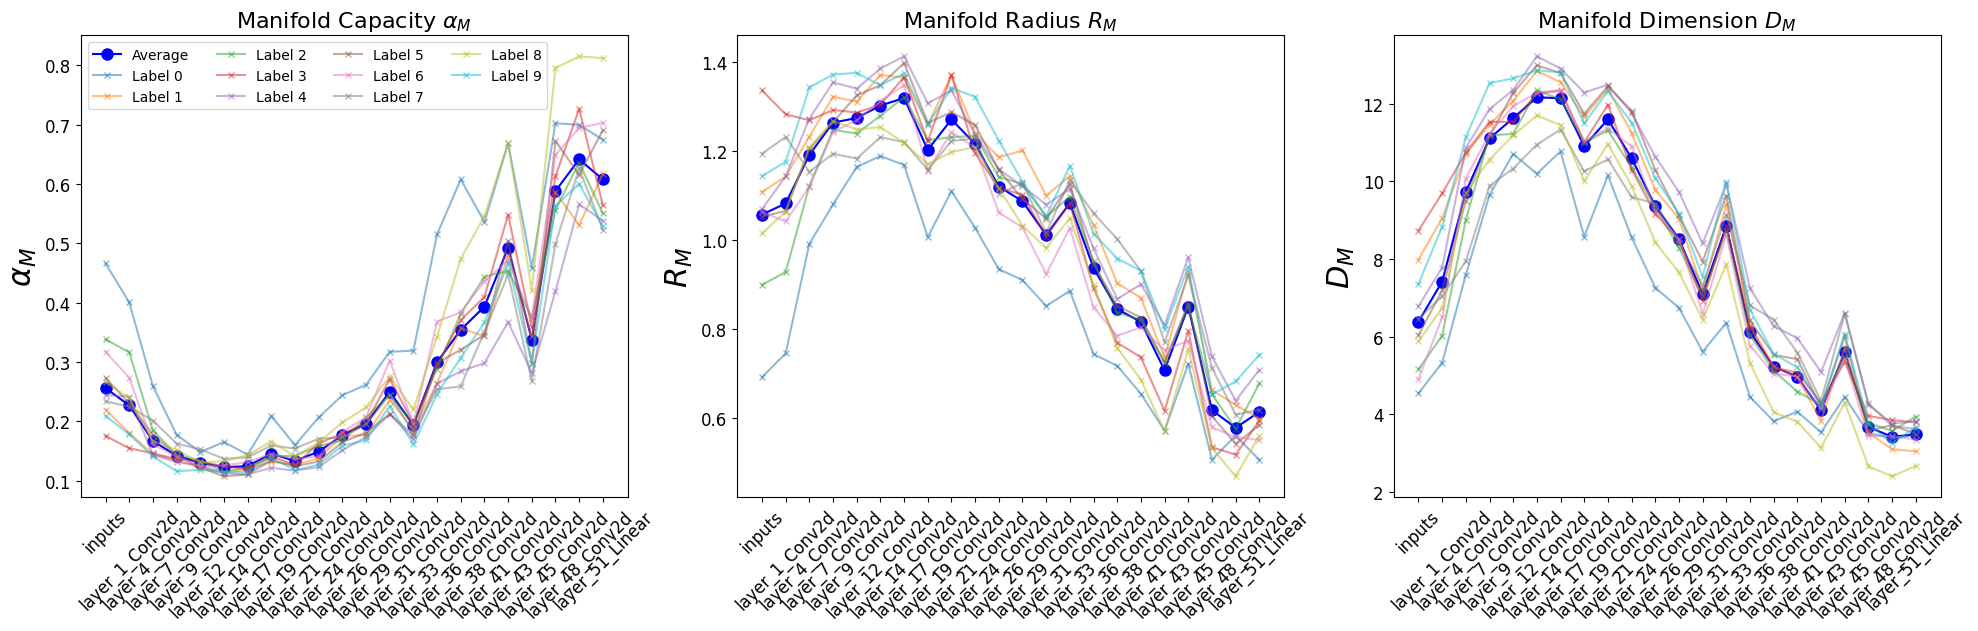

In [33]:
network_capacity_summary(alphas,radii,dims,mean_alphas,mean_radii,mean_dims,layer_names,labels)

Are these results more in line with what you'd expect? Does this make sense in light of the training setup?

#### **Exercises**
Here are a few suggestions for exploring MMCR a bit further:
1. Train a linear (or very shallow) classifier on the learned embeddings -- how well does it do? This is a standard evaluation technique for SSL.

2. Use your favorite dimensionality reduction technique (PCA, UMAP, t-SNE, etc.) to project MMCR embeddings to 2D and visualize them. Try looking at both class manifolds (embeddings of many different elements of each class) and augmentation manifolds (one exemplar from each class with $N$ random augmentations applied).

3. Try different training configurations -- in particular, try varying the number of views (augmentations) supplied for each image. This is one of the most important parameters for MMCR, as it determines the number of points contributing to the computation of centroid manifolds in the loss.

4. Train another model using SimCLR (loss function implemented below) and compare its performance to MMCR. 

In [ ]:
class SimCLRLoss(nn.Module):
    """
    SimCLR loss function implementation.
    Adapted from SupCon loss https://github.com/HobbitLong/SupContrast/blob/master/losses.py
    """
    def __init__(self, n_views, temperature=0.5):
        super(MMCRLoss, self).__init__()
        self.n_views = n_views # number of augmented views to expect per image
        self.temperature = temperature
    
    def forward(self, z):
        """
        Args:
            z: Tensor of shape (batch_size * n_views, feature_dim)
               Contains projections for all views of all images
        
        Returns:
            loss: MMCR loss value
        """
        # Normalize representations to unit sphere
        z = F.normalize(z, dim=-1)
        
        # Reshape to (batch_size, n_views, feature_dim)
        z = einops.rearrange(z, "(B N) C -> B N C", N=self.n_views)
        batch_size = z.shape[0]
        
        mask = torch.eye(batch_size,dtype=torch.float32).to(z.device)
        z_flat = torch.cat(torch.unbind(z,dim=1),dim=0)
        cos_sim_over_t = torch.div(torch.matmul(z_flat, z_flat.T), self.temperature)
        
        # for numerical stability, we subtract the max value in each row
        sim_max, _ = torch.max(cos_sim_over_t, dim=1, keepdim=True)
        logits = cos_sim_over_t - sim_max.detach()

        # tile mask
        mask = mask.repeat(self.n_views, self.n_views)
        # mask out self-contrast
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * self.n_views).view(-1, 1).to(mask.device),
            0
        ).to(mask.device)
        mask = mask * logits_mask
        
        # compute log prob
        exp_logits = torch.exp(logits) * logits_mask # no self contrast
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
        mask_pos_pairs = mask.sum(1)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_pos_pairs

        # loss
        loss = -mean_log_prob_pos
        loss = loss.view(self.n_views, batch_size).mean()

        return loss
